# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, DynamicPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

*data for backtesting*

In [3]:
file_bt_price = 'kospi200_bt_prices_040102_241023.csv'
file_bt_ratio = 'kospi200_bt_ratios_040131_240930.csv'

# Data

## Price

In [4]:
file = 'kospi200_prices.csv'

# Uncomment for backtesting
#file = file_bt_price

In [5]:
k200 = DataManager(
    universe = 'kospi200',
    file = file,
    path = path_data
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-25 uploaded.
df_prices updated


In [6]:
df_k200 = k200.df_prices.ffill()
assetnames_k200 = k200.get_names()

## Ratios

In [7]:
WidgetUniverse

In [8]:
is_backtest = True if k200.file_historical == file_bt_price else False

In [9]:
file = 'kospi200_ratios.csv' if not is_backtest else file_bt_ratio
fr = FinancialRatios(file, path_data)

Financial ratios of 201 stocks from 2023-01-02 to 2024-10-25 loaded


In [10]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1) 
)
fr.download(tickers, start, **kw) if not is_backtest and WidgetUniverse.values(0) else None

In [ ]:
fr.util_compare_periods(df_k200)

In [11]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-10-25


ticker
010060    0.000000
003030    0.006211
016380    0.012422
009970    0.018634
047040    0.024845
            ...   
009420    0.975155
329180    0.981366
377300    0.987578
450080    0.993789
004800    1.000000
Name: PER, Length: 162, dtype: float64

In [12]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2023-01-02    1.115655
        2023-01-03    1.120757
        2023-01-04    1.146513
        2023-01-05    1.162310
        2023-01-06    1.167412
                        ...   
105630  2024-10-21    0.747569
        2024-10-22    0.731519
        2024-10-23    0.726519
        2024-10-24    0.755069
        2024-10-25    0.737044
Name: PER, Length: 88315, dtype: float64

In [13]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02
end,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25
mean,105856.3,69.9,2.3,8746.6,2.4,1815.7
std,3555.0,41.1,0.3,1367.9,0.1,122.3


## Reshape
Interpolate & Reshape for backtesting

In [14]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

# Backtest

## Example

In [16]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [17]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 247,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

201 assets from 2021-01-04 to 2024-10-25 uploaded.
running self.util_check_days_in_year to check days in a year


In [19]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [20]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [21]:
kwargs_build = dict(
    name=fratio, select='f-ratio', weigh='Equally', 
    n_assets=10, freq='1y', lookback=0,
    df_ratio=df_ratio, ratio_descending=False
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, PER


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

Returning stats


,PER,KODEX200
start,2021-01-03,2021-01-03
end,2024-10-25,2024-10-25
total_return,0.033598,-0.073811
cagr,0.008715,-0.019933
calmar,0.038558,-0.058084
max_drawdown,-0.226021,-0.343167
avg_drawdown,-0.035972,-0.087863
avg_drawdown_days,79.375,229.333333
daily_vol,0.158852,0.180857
daily_sharpe,0.135248,-0.023216


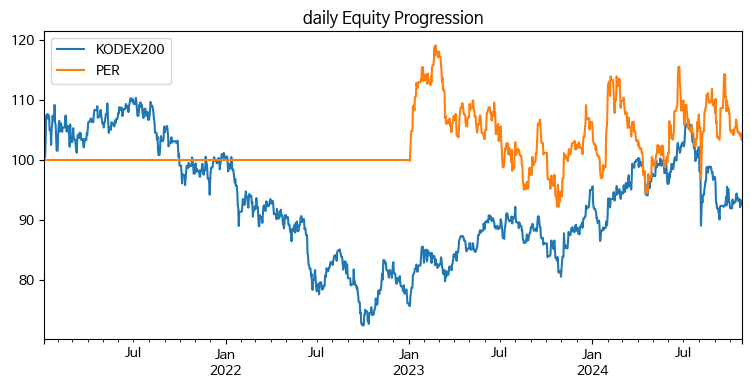

In [22]:
bm.run(figsize=(9,4), stats_sort_by='cagr')

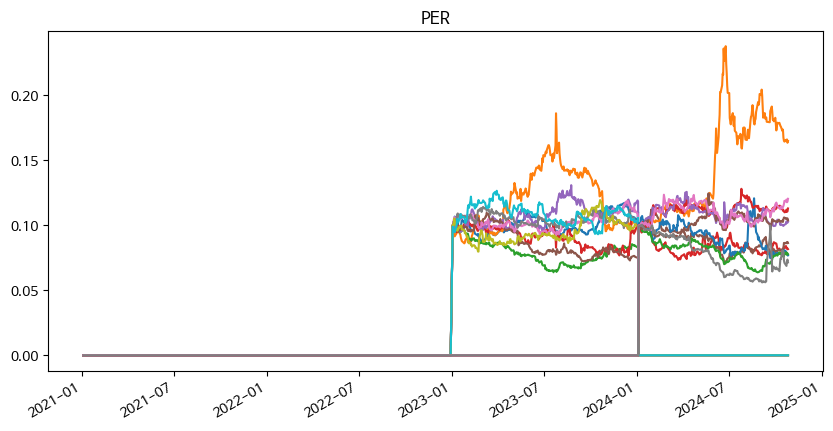

In [23]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [24]:
len(df_k200)

5142

In [25]:
n_val = 400
n_lb = 100
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-n_lb:]

In [35]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 241,
    asset_names = assetnames_k200
)

### Cross-validate

In [28]:
from itertools import product

p_args = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER'],
    p_ast = [5, 10, 20, 30],
    p_freq = ['6m', '1y', '2y'],
    p_lb = [0, '1w', '2w', '1m', '2m']
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]
params[0]

{'name': 'PER:a5/f6m/lb0',
 'df_ratio': 'PER',
 'n_assets': 5,
 'freq': '6m',
 'lookback': 0}

In [29]:
convert_args = lambda p: [{**x, 'df_ratio': fratios_dict[x['df_ratio']]} for x in p]

In [36]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2023-03-03 uploaded.
running self.util_check_days_in_year to check days in a year


In [37]:
kwa_list = convert_args(params)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

60 jobs prepared for cross-validation


In [38]:
kw_batch = dict(size_batch=10, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 60 strategies: PER:a5/f6m/lb0, PER:a5/f6m/lb1w, ... , PER:a30/f2y/lb2m


100%|███████████████████████████████████████████████████████████████| 18/18 [01:40<00:00,  5.56s/it]


91.4 mins elapsed, 0.0 secs paused (0.0%)
Temp batch files deleted


### Visualize

In [39]:
file = 'param_per_k2hl.csv'

*Save param study*

In [40]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_per_k2hl.csv saved
60 param sets with 18 iterations per set


*Load param study*

In [41]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_per_k2hl.csv
60 param sets with 18 iterations per set


In [42]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv)

Returning cagr of KODEX200 from 2004-01-02 to 2023-03-03


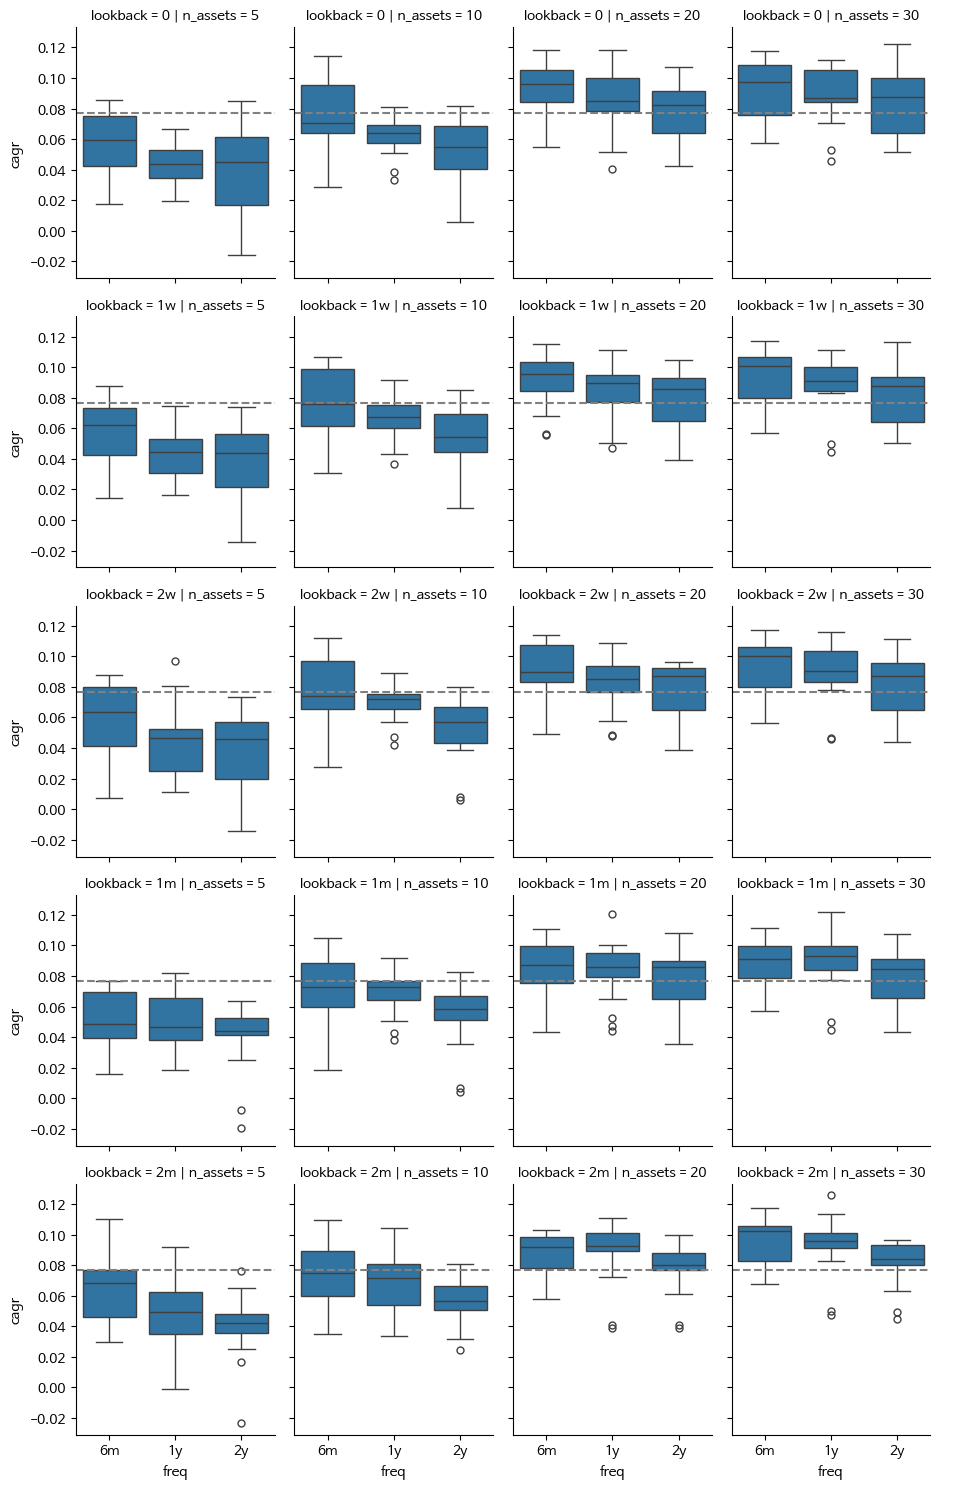

In [45]:
#kw = {'x':'lookback', 'row':'freq', 'col':'n_assets'}
#kw = {'hue':'lookback', 'col':'freq', 'x':'n_assets'}
#kw = {'col':'freq', 'x':'n_assets', 'kind':'box'}
kw = {'x':'freq', 'col':'n_assets', 'kind':'box', 'row':'lookback'}
#kw = {'x':'freq', 'col':'n_assets', 'hue':'lookback'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=3, aspect=.8, **kw)

### Validation

In [46]:
bm = BacktestManager(df_val, **kwargs_bm)

426 assets from 2022-10-11 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year


In [47]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [50]:
p_comb = [[20, '1y', '2m'], [30, '1y', '2m'], [20, '6m', '1w']]
kwa_list = [{'name':'PER:a{}/f{}'.format(*x), 
             'n_assets':x[0], 'freq':x[1], 'lookback':x[2]} for x in p_comb]

Backtesting 4 strategies: KODEX200, PER:a20/f1y, PER:a30/f1y, PER:a20/f6m


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]

Returning stats


,KODEX200,PER:a20/f6m,PER:a30/f1y,PER:a20/f1y
start,2022-10-10,2022-10-10,2022-10-10,2022-10-10
end,2024-10-23,2024-10-23,2024-10-23,2024-10-23
total_return,0.27411,0.148782,0.146711,0.130765
cagr,0.126287,0.070465,0.069517,0.06219
calmar,0.766328,0.651488,0.884681,0.498982
max_drawdown,-0.164794,-0.108159,-0.078578,-0.124633
avg_drawdown,-0.030918,-0.021709,-0.025835,-0.029052
avg_drawdown_days,22.586207,54.153846,58.5,70.6
daily_vol,0.182857,0.121151,0.109756,0.130845
daily_sharpe,0.759752,0.637522,0.683496,0.538675


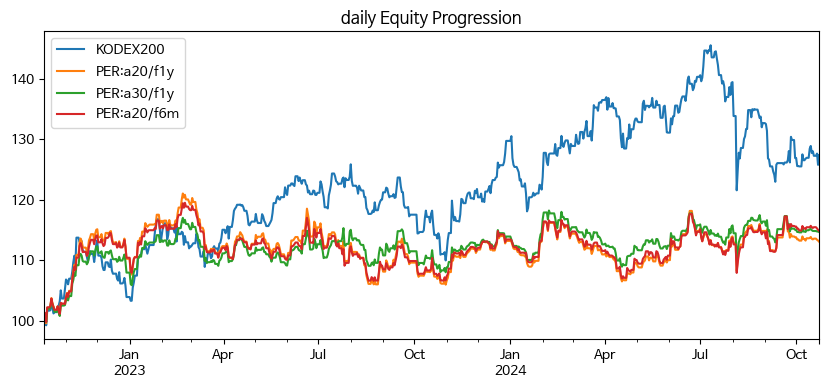

In [51]:
kwargs_build = dict(
    select='f-ratio', weigh='Equally', 
    ratio_descending=False, build_cv=False,
    df_ratio=fratios_dict['PER']
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

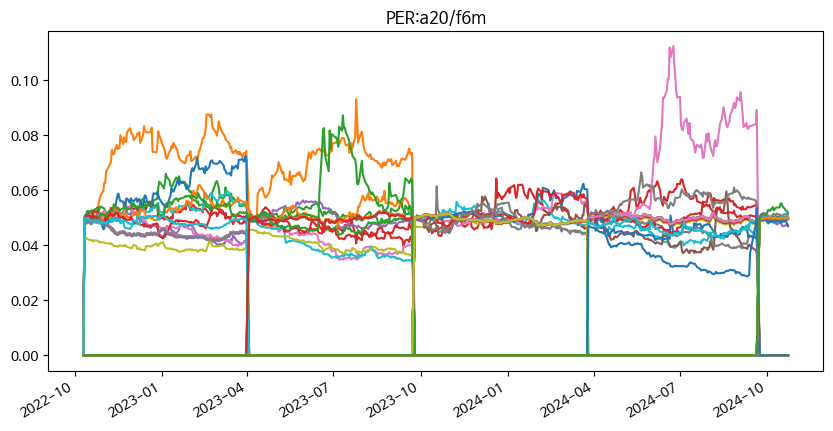

In [52]:
bm.plot_security_weights(3, legend=False)

# Transaction

In [20]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [21]:
kwargs = dict(
    name=fratio,
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    lookback='2m',
    df_additional=df_ratio,
    method_weigh='equally',
)
kwargs.update(DynamicPortfolio.check_init_args(fratio))

pf_per = DynamicPortfolio(df_k200, **kwargs)

201 assets from 2021-01-04 to 2024-10-25 uploaded.
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [22]:
pf_per.view_record()

ERROR: No transaction record


In [23]:
pf_per.valuate()

ERROR: No transaction record


In [24]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [28]:
kwargs_trs = dict(
    n_assets = 20,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
ERROR: no ratio for "None of [Index(['2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',\n       '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-11',\n       '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',\n       '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',\n       '2022-11-28', '2022-11-29', '2022-11-30', '2022-12-01', '2022-12-02',\n       '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',\n       '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',\n       '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',\n       '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29'],\n      dtype='object', name='Date')] are in the [index]"


name   price  transaction  net weight weight*
date       asset                                                    
2023-09-27 011200       HMM   16260           27   27  0.050  0.0534
           137310  에스디바이오센서   11370           39   39  0.050  0.0540
           036460    한국가스공사   23900           18   18  0.050  0.0523
           016380      KG스틸    7900           56   56  0.050  0.0538
           078930        GS   39900           11   11  0.050  0.0534
           000880        한화   23950           18   18  0.050  0.0525
           139480       이마트   70400            6    6  0.050  0.0514
           009970   영원무역홀딩스   80500            5    5  0.050  0.0490
           001120   LX인터내셔널   28550           15   15  0.050  0.0521
           000670        영풍  514000            0    0  0.050  0.0000
           010060    OCI홀딩스   97500            4    4  0.050  0.0475
           316140    우리금융지주   12260           36   36  0.050  0.0537
           138930   BNK금융지주    6850           65   65  0.050  0.0542
           003030    세아제강지주  218000            2    2  0.050  0.0531
           088350      한화생명    2855          157  157  0.050  0.0545
           375500     DL이앤씨   31150           14   14  0.050  0.0531
           175330    JB금융지주    9960           45   45  0.050  0.0545
           267250      HD현대   66300            6    6  0.050  0.0484
           024110      기업은행   11210           40   40  0.050  0.0546
           139130   DGB금융지주    7870           57   57  0.050  0.0546

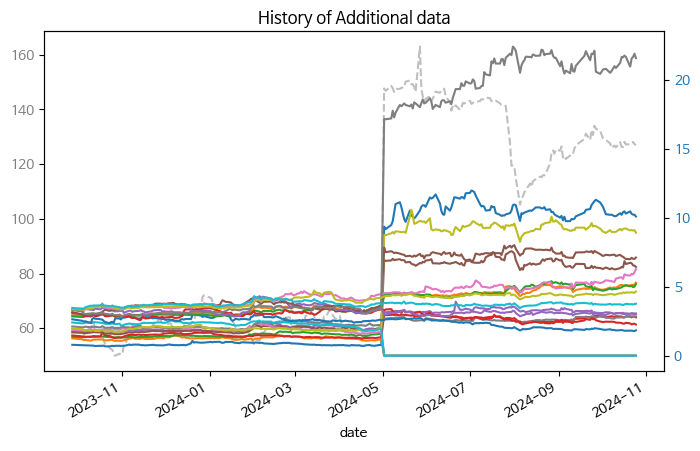

In [29]:
_ = pf_per.check_additional(plot=True, legend=False)